# SEN12FLOODS Dataset - Exploratory Data Analysis (EDA)

## Mục tiêu và Tổng quan

**SEN12FLOODS** là dataset về flood detection sử dụng dữ liệu vệ tinh Sentinel-1 và Sentinel-2. Notebook này thực hiện phân tích khám phá dữ liệu (EDA) để hiểu rõ:

### Mục tiêu chính:
1. **Khám phá cấu trúc dataset** - Hiểu tổ chức files và folders
2. **Phân tích sensor data** - So sánh Sentinel-1 (SAR) vs Sentinel-2 (Optical)
3. **Data cleaning** - Loại bỏ invalid files để cải thiện training
4. **Visualization** - Tạo biểu đồ và sample images
5. **Export clean dataset** - Chuẩn bị data sạch cho training

### Về Sensor Data:
- **Sentinel-1**: SAR (Synthetic Aperture Radar) - hoạt động 24/7, không bị ảnh hưởng bởi mây
- **Sentinel-2**: Optical imagery - chất lượng hình ảnh cao, nhiều spectral bands

### Workflow:
1. Chạy notebook này TRƯỚC để clean data
2. Sau để train models
3. Training script sẽ tự động sử dụng clean dataset

---


## 1. Import Libraries và Setup

Import tất cả thư viện cần thiết và thiết lập cấu hình cơ bản:

### Libraries được sử dụng:
- **pandas, numpy**: Data manipulation và numerical computing
- **matplotlib, seaborn**: Visualization và plotting  
- **rasterio**: Đọc/xử lý dữ liệu GeoTIFF (satellite images)
- **cv2, PIL**: Image processing
- **glob, os, json**: File operations và metadata handling


In [14]:
import os
import glob
import json
import random
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import rasterio
import cv2
from PIL import Image

# Set style cho plots - tạo giao diện đẹp hơn
plt.style.use('default')
sns.set_palette("husl")

# Set random seeds cho reproducibility - đảm bảo kết quả nhất quán
seed = 42
random.seed(seed)
np.random.seed(seed)

print("=" * 60)
print("SEN12FLOODS DATASET - EXPLORATORY DATA ANALYSIS")
print("=" * 60)


SEN12FLOODS DATASET - EXPLORATORY DATA ANALYSIS


## 2. Cấu hình Đường dẫn và Khám phá Cấu trúc Dữ liệu

Trong cell này, chúng ta sẽ:

### Mục tiêu:
1. **Thiết lập data path** - Đường dẫn đến SEN12FLOODS dataset
2. **Scan tất cả files** - Tìm và đếm các file .tif trong dataset
3. **Phân tích structure** - Hiểu cách tổ chức folders và files

### Cấu trúc Dataset:
- Mỗi **folder** đại diện cho một **scene/region** cụ thể
- Mỗi scene chứa nhiều **bands** từ Sentinel-1 và Sentinel-2
- Files được tổ chức theo **sensor type** và **spectral bands**


In [15]:
# Đường dẫn đến thư mục dữ liệuN
data_dir = "/home/nhotin/tinltn/dat301m/as/sen12floods/data/sen12floods1"

print(f"Thư mục dữ liệu: {data_dir}")

# Kiểm tra xem thư mục có tồn tại không
if not os.path.exists(data_dir):
    print("Lỗi: Thư mục dữ liệu không tồn tại!")
    print("Vui lòng cập nhật đường dẫn data_dir phù hợp")
else:
    print("Thư mục dữ liệu tồn tại")

print("\n" + "="*50)
print("1. KHÁM PHÁ CẤU TRÚC DỮ LIỆU")
print("="*50)

# Liệt kê tất cả file TIFF một cách đệ quy
tif_files = glob.glob(os.path.join(data_dir, "**/*.tif"), recursive=True)
print(f"Tổng số file TIFF tìm thấy: {len(tif_files):,}")

# Hiển thị mẫu đường dẫn file để hiểu cấu trúc
print("\nMẫu đường dẫn file:")
for i, f in enumerate(tif_files[:5]):
    relative_path = f.replace(data_dir, "")
    print(f"  {i+1}. {relative_path}")

# Phân tích cấu trúc thư mục - mỗi thư mục con thường đại diện cho một khu vực/scene
folder_names = [os.path.basename(os.path.dirname(file)) for file in tif_files]
folder_counts = Counter(folder_names)

print(f"\nSố thư mục duy nhất: {len(folder_counts)}")
print(f"Thư mục có nhiều file nhất: {folder_counts.most_common(1)[0][0]} ({folder_counts.most_common(1)[0][1]} files)")
print(f"Thư mục có ít file nhất: {folder_counts.most_common()[-1][0]} ({folder_counts.most_common()[-1][1]} files)")

# Hiển thị top 10 thư mục có nhiều file nhất
print(f"\nTop 10 thư mục có nhiều file nhất:")
for i, (folder, count) in enumerate(folder_counts.most_common(10)):
    print(f"  {i+1:2d}. {folder:30} - {count:3d} files")


Thư mục dữ liệu: /home/nhotin/tinltn/dat301m/as/sen12floods/data/sen12floods1
Thư mục dữ liệu tồn tại

1. KHÁM PHÁ CẤU TRÚC DỮ LIỆU
Tổng số file TIFF tìm thấy: 36,052

Mẫu đường dẫn file:
  1. /0095/S2_2019-02-06_B05.tif
  2. /0095/S1B_IW_GRDH_1SDV_20190209T181740_20190209T181805_014873_01BC28_D12A_corrected_VV.tif
  3. /0095/S2_2019-02-11_B04.tif
  4. /0095/S1B_IW_GRDH_1SDV_20181223T181742_20181223T181807_014173_01A569_9A1D_corrected_VH.tif
  5. /0095/S2_2019-01-02_B01.tif

Số thư mục duy nhất: 335
Thư mục có nhiều file nhất: 0267 (170 files)
Thư mục có ít file nhất: 55 (16 files)

Top 10 thư mục có nhiều file nhất:
   1. 0267                           - 170 files
   2. 0266                           - 170 files
   3. 0244                           - 166 files
   4. 0144                           - 166 files
   5. 0253                           - 166 files
   6. 0263                           - 166 files
   7. 0140                           - 164 files
   8. 0254                      

## 3. Phân loại theo Loại Sensor

Bước này rất quan trọng để hiểu rõ về 2 loại sensor khác nhau:

### Sentinel-1 (SAR - Synthetic Aperture Radar):
- **Radar data** - hoạt động 24/7, không bị ảnh hưởng bởi thời tiết/mây
- **Tốt cho flood detection** vì nước phản xạ radar signal rất đặc biệt
- Thường có **2 bands**: VV và VH polarization
- **Tần số**: C-band (5.4 GHz)

### Sentinel-2 (Optical Imagery):
- **Multispectral optical** - chụp ảnh như máy ảnh thông thường nhưng với nhiều bands
- **13 spectral bands** - từ visible light đến near-infrared
- **Độ phân giải cao** - 10m, 20m, 60m tùy theo band
- **Bị ảnh hưởng bởi mây** - không thể chụp qua mây dày

### Classification Logic:
Code sẽ phân loại dựa trên đường dẫn file - files có "S1" là Sentinel-1, "S2" là Sentinel-2


In [16]:
print("\n" + "="*50)
print("2. PHÂN LOẠI THEO LOẠI SENSOR")
print("="*50)

def classify_sensor(file_path):
    """
    Phân loại file theo loại sensor dựa trên tên file
    
    Parameters:
    -----------
    file_path : str
        Đường dẫn đến file
        
    Returns:
    --------
    str : Loại sensor ('Sentinel-1', 'Sentinel-2', hoặc 'Other')
    """
    fname = os.path.basename(file_path)
    if "/S1" in file_path or fname.startswith("S1"):
        return "Sentinel-1"
    elif "/S2" in file_path or fname.startswith("S2"):
        return "Sentinel-2"
    else:
        return "Other"

# Phân loại từng file theo sensor
sensor_types = [classify_sensor(path) for path in tif_files]

# Tạo DataFrame để dễ phân tích
df_sensors = pd.DataFrame({
    "filepath": tif_files,
    "sensor": sensor_types,
    "folder": folder_names
})

# Thống kê theo sensor
sensor_counts = df_sensors["sensor"].value_counts()
print("Phân bố theo loại sensor:")
for sensor, count in sensor_counts.items():
    percentage = (count / len(tif_files)) * 100
    print(f"  {sensor:12}: {count:8,} files ({percentage:.1f}%)")

# Tách danh sách theo sensor để phân tích riêng
sentinel1_files = df_sensors[df_sensors.sensor == "Sentinel-1"]["filepath"].tolist()
sentinel2_files = df_sensors[df_sensors.sensor == "Sentinel-2"]["filepath"].tolist()
other_files = df_sensors[df_sensors.sensor == "Other"]["filepath"].tolist()

print(f"\nChi tiết phân loại:")
print(f"  Sentinel-1: {len(sentinel1_files):,} files")
print(f"  Sentinel-2: {len(sentinel2_files):,} files")
print(f"  Other: {len(other_files):,} files")

# Hiển thị mẫu file names cho mỗi sensor type
if sentinel1_files:
    print(f"\nMẫu file Sentinel-1:")
    for i, f in enumerate(sentinel1_files[:3]):
        print(f"  {os.path.basename(f)}")

if sentinel2_files:
    print(f"\nMẫu file Sentinel-2:")
    for i, f in enumerate(sentinel2_files[:3]):
        print(f"  {os.path.basename(f)}")



2. PHÂN LOẠI THEO LOẠI SENSOR
Phân bố theo loại sensor:
  Sentinel-2  :   26,844 files (74.5%)
  Sentinel-1  :    9,208 files (25.5%)

Chi tiết phân loại:
  Sentinel-1: 9,208 files
  Sentinel-2: 26,844 files
  Other: 0 files

Mẫu file Sentinel-1:
  S1B_IW_GRDH_1SDV_20190209T181740_20190209T181805_014873_01BC28_D12A_corrected_VV.tif
  S1B_IW_GRDH_1SDV_20181223T181742_20181223T181807_014173_01A569_9A1D_corrected_VH.tif
  S1A_IW_GRDH_1SDV_20190127T182632_20190127T182657_025667_02D9D5_1BDD_corrected_VH.tif

Mẫu file Sentinel-2:
  S2_2019-02-06_B05.tif
  S2_2019-02-11_B04.tif
  S2_2019-01-02_B01.tif


## 4. Tải và Phân tích Metadata

Metadata rất quan trọng để hiểu về labels (flood/non-flood) của từng scene:

### Metadata Files:
- **S1list.json**: Chứa metadata cho Sentinel-1 data
- **S2list.json**: Chứa metadata cho Sentinel-2 data

### Label Logic:
- Mỗi **folder/scene** được gán label dựa trên metadata
- **Label 1**: Có flooding (bất kỳ entry nào trong folder có FLOODING=True)
- **Label 0**: Không có flooding (tất cả entries đều FLOODING=False)

### Phân tích Distribution:
- Xem phân bố giữa flooded vs non-flooded scenes
- Quan trọng để hiểu **class imbalance** trong dataset


In [17]:
print("\n" + "="*50)
print("3. PHÂN TÍCH METADATA VÀ LABELS")
print("="*50)

# Đường dẫn đến file JSON chứa metadata
s1_json_path = os.path.join(data_dir, "S1list.json")
s2_json_path = os.path.join(data_dir, "S2list.json")

# Dictionary để lưu flood labels cho từng folder/scene
flood_labels = {}

# Tải và xử lý S1 metadata
if os.path.exists(s1_json_path):
    with open(s1_json_path, "r") as f:
        s1_data = json.load(f)
    print(f"Đã tải S1list.json - {len(s1_data)} entries")
    
    # Xây dựng mapping flood labels từ S1 data
    # Logic: nếu có bất kỳ entry nào trong folder có FLOODING=True thì folder đó được gán label 1
    for folder, details in s1_data.items():
        flood_status = any(
            entry.get("FLOODING", False)
            for key, entry in details.items() 
            if isinstance(entry, dict) and "FLOODING" in entry
        )
        flood_labels[folder] = int(flood_status)
else:
    print("Không tìm thấy S1list.json")

# Tải và xử lý S2 metadata (tương tự S1)
if os.path.exists(s2_json_path):
    with open(s2_json_path, "r") as f:
        s2_data = json.load(f)
    print(f"Đã tải S2list.json - {len(s2_data)} entries")
    
    # Cập nhật mapping với S2 data
    for folder, details in s2_data.items():
        flood_status = any(
            entry.get("FLOODING", False)
            for key, entry in details.items() 
            if isinstance(entry, dict) and "FLOODING" in entry
        )
        flood_labels[folder] = int(flood_status)
else:
    print("Không tìm thấy S2list.json")

print(f"\nTổng số thư mục có label: {len(flood_labels)}")

# Phân tích distribution của labels trong toàn bộ dataset
dataset_folder_names = [os.path.basename(os.path.dirname(file)) for file in tif_files]
mapped_labels = [flood_labels.get(folder, 0) for folder in dataset_folder_names]  # Default 0 nếu không có label
label_distribution = Counter(mapped_labels)

print("Phân bố labels trong dataset:")
total_files = len(mapped_labels)
for label, count in label_distribution.items():
    label_name = "Flooding" if label == 1 else "Non-flooding"
    percentage = (count / total_files) * 100
    print(f"  {label_name:15}: {count:8,} files ({percentage:.1f}%)")

# Hiển thị một số sample folders và labels
print(f"\nSample flood labels:")
sample_folders = list(flood_labels.items())[:10]
for folder, label in sample_folders:
    label_name = "Flooded" if label == 1 else "Non-flooded"
    print(f"  {folder:30} -> {label_name}")



3. PHÂN TÍCH METADATA VÀ LABELS
Đã tải S1list.json - 335 entries
Đã tải S2list.json - 335 entries

Tổng số thư mục có label: 335
Phân bố labels trong dataset:
  Non-flooding   :   11,719 files (32.5%)
  Flooding       :   24,333 files (67.5%)

Sample flood labels:
  0063                           -> Non-flooded
  0200                           -> Flooded
  0004                           -> Non-flooded
  0307                           -> Flooded
  0167                           -> Flooded
  0205                           -> Flooded
  0166                           -> Flooded
  0240                           -> Flooded
  0123                           -> Non-flooded
  61                             -> Flooded


## 5. Data Cleaning - Loại bỏ Invalid Files

Đây là bước **quan trọng nhất** để cải thiện chất lượng training:

### Mục tiêu Data Cleaning:
1. **Phát hiện invalid files**: Files có dữ liệu không hợp lệ
2. **Loại bỏ problematic data**: Files toàn NaN, toàn số 0, hoặc corrupt
3. **Tạo clean dataset**: Chỉ giữ lại files chất lượng tốt
4. **Export clean info**: Lưu thông tin để training script sử dụng

### Các loại Invalid Files:
- **All NaN**: Files chỉ chứa NaN values
- **All zeros**: Files chỉ chứa giá trị 0
- **Cannot read**: Files bị corrupt hoặc format sai
- **Empty files**: Files có kích thước 0 bytes

### Output Files:
- `clean_dataset_info.json`: Thông tin về clean dataset
- `invalid_files_info.json`: Thông tin về invalid files
- `flood_labels_mapping.json`: Mapping từ folder đến flood labels



In [18]:
print("\n" + "="*50)
print("4. DATA CLEANING - LOẠI BỎ INVALID FILES")
print("="*50)

def is_valid_file(file_path):
    """
    Kiểm tra xem file có dữ liệu hợp lệ hay không
    
    Parameters:
    -----------
    file_path : str
        Đường dẫn đến file
        
    Returns:
    --------
    bool : True nếu file hợp lệ, False nếu invalid
    """
    try:
        # Kiểm tra file tồn tại và có kích thước > 0
        if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
            return False
            
        with rasterio.open(file_path) as src:
            # Kiểm tra metadata cơ bản
            if src.width == 0 or src.height == 0 or src.count == 0:
                return False
                
            # Đọc dữ liệu từ band đầu tiên
            data = src.read(1).astype(float)
            
            # Kiểm tra dữ liệu hợp lệ
            all_nan = np.all(np.isnan(data))
            all_zero = np.all(data == 0)
            
            # File invalid nếu toàn NaN hoặc toàn số 0
            if all_nan or all_zero:
                return False
                
            return True
            
    except Exception as e:
        # Nếu có lỗi đọc file thì coi như invalid
        return False

print("Đang kiểm tra tính hợp lệ của tất cả files...")
print("Quá trình này có thể mất vài phút...")

# Tạo danh sách để lưu kết quả
valid_files = []
invalid_files = []
invalid_reasons = []

# Kiểm tra từng file
total_files = len(tif_files)
for i, file_path in enumerate(tif_files):
    if (i + 1) % 100 == 0:  # Progress indicator
        print(f"   Đã kiểm tra {i+1}/{total_files} files ({(i+1)/total_files*100:.1f}%)")
    
    if is_valid_file(file_path):
        valid_files.append(file_path)
    else:
        invalid_files.append(file_path)
        # Thêm thông tin chi tiết về lý do invalid
        try:
            with rasterio.open(file_path) as src:
                data = src.read(1).astype(float)
                if np.all(np.isnan(data)):
                    invalid_reasons.append("All NaN")
                elif np.all(data == 0):
                    invalid_reasons.append("All zeros")
                else:
                    invalid_reasons.append("Other error")
        except:
            invalid_reasons.append("Cannot read")

print(f"\nHoàn thành kiểm tra {total_files} files!")



4. DATA CLEANING - LOẠI BỎ INVALID FILES
Đang kiểm tra tính hợp lệ của tất cả files...
Quá trình này có thể mất vài phút...


   Đã kiểm tra 100/36052 files (0.3%)
   Đã kiểm tra 200/36052 files (0.6%)
   Đã kiểm tra 300/36052 files (0.8%)
   Đã kiểm tra 400/36052 files (1.1%)
   Đã kiểm tra 500/36052 files (1.4%)
   Đã kiểm tra 600/36052 files (1.7%)
   Đã kiểm tra 700/36052 files (1.9%)
   Đã kiểm tra 800/36052 files (2.2%)
   Đã kiểm tra 900/36052 files (2.5%)
   Đã kiểm tra 1000/36052 files (2.8%)
   Đã kiểm tra 1100/36052 files (3.1%)
   Đã kiểm tra 1200/36052 files (3.3%)
   Đã kiểm tra 1300/36052 files (3.6%)
   Đã kiểm tra 1400/36052 files (3.9%)
   Đã kiểm tra 1500/36052 files (4.2%)
   Đã kiểm tra 1600/36052 files (4.4%)
   Đã kiểm tra 1700/36052 files (4.7%)
   Đã kiểm tra 1800/36052 files (5.0%)
   Đã kiểm tra 1900/36052 files (5.3%)
   Đã kiểm tra 2000/36052 files (5.5%)
   Đã kiểm tra 2100/36052 files (5.8%)
   Đã kiểm tra 2200/36052 files (6.1%)
   Đã kiểm tra 2300/36052 files (6.4%)
   Đã kiểm tra 2400/36052 files (6.7%)
   Đã kiểm tra 2500/36052 files (6.9%)
   Đã kiểm tra 2600/36052 files (7

In [19]:
# Thống kê kết quả cleaning
print(f"\nKẾT QUẢ DATA CLEANING:")
print(f"  Valid files: {len(valid_files):,} ({len(valid_files)/total_files*100:.1f}%)")
print(f"  Invalid files: {len(invalid_files):,} ({len(invalid_files)/total_files*100:.1f}%)")

# Phân tích nguyên nhân invalid
if invalid_files:
    print(f"\nNGUYÊN NHÂN INVALID:")
    reason_counts = Counter(invalid_reasons)
    for reason, count in reason_counts.items():
        print(f"  {reason}: {count:,} files")

# Phân loại valid files theo sensor
valid_sentinel1_files = []
valid_sentinel2_files = []
valid_other_files = []

for file_path in valid_files:
    sensor = classify_sensor(file_path)
    if sensor == "Sentinel-1":
        valid_sentinel1_files.append(file_path)
    elif sensor == "Sentinel-2":
        valid_sentinel2_files.append(file_path)
    else:
        valid_other_files.append(file_path)

print(f"\nVALID FILES THEO SENSOR:")
print(f"  Sentinel-1: {len(valid_sentinel1_files):,} files")
print(f"  Sentinel-2: {len(valid_sentinel2_files):,} files")
print(f"  Other: {len(valid_other_files):,} files")

# Cập nhật flood labels chỉ cho valid files
valid_folders = set()
for file_path in valid_files:
    folder_name = os.path.basename(os.path.dirname(file_path))
    valid_folders.add(folder_name)

# Tạo clean flood labels chỉ cho folders có valid files
clean_flood_labels = {folder: label for folder, label in flood_labels.items() 
                     if folder in valid_folders}

print(f"\nFLOOD LABELS SAU CLEANING:")
clean_label_distribution = Counter(clean_flood_labels.values())
for label, count in clean_label_distribution.items():
    label_name = "Flooded" if label == 1 else "Non-flooded"
    print(f"  {label_name}: {count:,} folders")

# Lưu thông tin cleaning
clean_data_file = os.path.join(data_dir, 'clean_dataset_info.json')
with open(clean_data_file, 'w') as f:
    clean_info_serializable = {
        'valid_files': valid_files,
        'valid_sentinel1_files': valid_sentinel1_files,
        'valid_sentinel2_files': valid_sentinel2_files,
        'clean_flood_labels': clean_flood_labels,
        'cleaning_stats': {
            'total_original_files': total_files,
            'valid_files_count': len(valid_files),
            'invalid_files_count': len(invalid_files),
            'cleaning_rate': len(valid_files) / total_files * 100
        }
    }
    json.dump(clean_info_serializable, f, indent=2)

print(f"\nĐã lưu thông tin clean dataset:")
print(f"{clean_data_file}")
print(f"Training script sẽ tự động load clean dataset này!")

# Tạo danh sách invalid files để review nếu cần
invalid_files_info = {
    'invalid_files': invalid_files,
    'invalid_reasons': invalid_reasons
}

invalid_files_file = os.path.join(data_dir, 'invalid_files_info.json')
with open(invalid_files_file, 'w') as f:
    json.dump(invalid_files_info, f, indent=2)

# Lưu flood labels mapping
labels_file = os.path.join(data_dir, 'flood_labels_mapping.json')
with open(labels_file, 'w') as f:
    json.dump(clean_flood_labels, f, indent=2)

print(f"Invalid files info: {invalid_files_file}")
print(f"Flood labels mapping: {labels_file}")
print(f"All files saved to: {data_dir}")

print(f"\n CLEAN DATASET ĐÃ SẴN SÀNG CHO TRAINING!")
print(f" Tỷ lệ data còn lại: {len(valid_files)/total_files*100:.1f}%")



KẾT QUẢ DATA CLEANING:
  Valid files: 33,259 (92.3%)
  Invalid files: 2,793 (7.7%)

NGUYÊN NHÂN INVALID:
  All zeros: 2,792 files
  Cannot read: 1 files

VALID FILES THEO SENSOR:
  Sentinel-1: 8,793 files
  Sentinel-2: 24,466 files
  Other: 0 files

FLOOD LABELS SAU CLEANING:
  Non-flooded: 134 folders
  Flooded: 201 folders

Đã lưu thông tin clean dataset:
/home/nhotin/tinltn/dat301m/as/sen12floods/data/sen12floods1/clean_dataset_info.json
Training script sẽ tự động load clean dataset này!
Invalid files info: /home/nhotin/tinltn/dat301m/as/sen12floods/data/sen12floods1/invalid_files_info.json
Flood labels mapping: /home/nhotin/tinltn/dat301m/as/sen12floods/data/sen12floods1/flood_labels_mapping.json
All files saved to: /home/nhotin/tinltn/dat301m/as/sen12floods/data/sen12floods1

 CLEAN DATASET ĐÃ SẴN SÀNG CHO TRAINING!
 Tỷ lệ data còn lại: 92.3%


## 6. Cập nhật Variables cho Clean Dataset

Sau khi data cleaning, chúng ta cần cập nhật các variables để sử dụng clean data cho các analysis tiếp theo:


In [20]:
# Cập nhật các biến để sử dụng clean data trong các cell tiếp theo
print(f"\nCẬP NHẬT VARIABLES CHO CLEAN DATASET:")
print(f"  • tif_files -> valid_files ({len(valid_files):,} files)")
print(f"  • sentinel1_files -> valid_sentinel1_files ({len(valid_sentinel1_files):,} files)")
print(f"  • sentinel2_files -> valid_sentinel2_files ({len(valid_sentinel2_files):,} files)")
print(f"  • flood_labels -> clean_flood_labels ({len(clean_flood_labels)} folders)")

# Override variables với clean data
tif_files = valid_files
sentinel1_files = valid_sentinel1_files
sentinel2_files = valid_sentinel2_files
flood_labels = clean_flood_labels

# Cập nhật DataFrame sensors với clean data
df_sensors = pd.DataFrame({
    "filepath": valid_files,
    "sensor": [classify_sensor(path) for path in valid_files],
    "folder": [os.path.basename(os.path.dirname(file)) for file in valid_files]
})

# Cập nhật các thống kê với clean data
folder_names = [os.path.basename(os.path.dirname(file)) for file in valid_files]
folder_counts = Counter(folder_names)

print(f"\nCLEAN DATASET ĐÃ SẴN SÀNG CHO ANALYSIS!")
print(f"Tỷ lệ data còn lại: {len(valid_files)/total_files*100:.1f}%")



CẬP NHẬT VARIABLES CHO CLEAN DATASET:
  • tif_files -> valid_files (33,259 files)
  • sentinel1_files -> valid_sentinel1_files (8,793 files)
  • sentinel2_files -> valid_sentinel2_files (24,466 files)
  • flood_labels -> clean_flood_labels (335 folders)

CLEAN DATASET ĐÃ SẴN SÀNG CHO ANALYSIS!
Tỷ lệ data còn lại: 92.3%


## 7. Phân tích Sentinel-2 Bands

Sentinel-2 có 13 spectral bands với wavelengths khác nhau, mỗi band cung cấp thông tin khác nhau:

### Các Bands chính:
- **B02 (Blue)**: 490nm - Phát hiện nước sâu
- **B03 (Green)**: 560nm - Vegetation peak reflection  
- **B04 (Red)**: 665nm - Chlorophyll absorption
- **B08 (NIR)**: 842nm - Vegetation structure
- **B11/B12 (SWIR)**: 1610nm/2190nm - Moisture content

### Analysis:
Code sẽ đếm số lượng files cho mỗi band và hiển thị wavelength information


In [21]:
print("\n" + "="*50)
print("4. PHÂN TÍCH BANDS SENTINEL-2")
print("="*50)

# Trích xuất thông tin band từ tên file Sentinel-2
s2_bands = []
for file in sentinel2_files:
    fname = os.path.basename(file)
    if "_B" in fname:  # File có format như S2_date_B04.tif
        band = fname.split("_B")[-1].split(".")[0]  # Lấy phần sau "_B" và trước ".tif"
        s2_bands.append(band)

s2_band_counts = Counter(s2_bands)
print("Phân bố các bands Sentinel-2:")
print("(Band numbers correspond to different spectral wavelengths)")

# Sắp xếp bands theo thứ tự số
for band in sorted(s2_band_counts.keys(), key=lambda x: int(x) if x.isdigit() else 999):
    count = s2_band_counts[band]
    # Thêm thông tin về wavelength cho từng band
    band_info = {
        '01': 'Coastal aerosol (443nm)',
        '02': 'Blue (490nm)', 
        '03': 'Green (560nm)',
        '04': 'Red (665nm)',
        '05': 'Red edge 1 (705nm)',
        '06': 'Red edge 2 (740nm)',
        '07': 'Red edge 3 (783nm)',
        '08': 'NIR (842nm)',
        '8A': 'Red edge 4 (865nm)',
        '09': 'Water vapour (945nm)',
        '11': 'SWIR 1 (1610nm)',
        '12': 'SWIR 2 (2190nm)'
    }
    description = band_info.get(band, '')
    print(f"  Band {band:3}: {count:,} files - {description}")

# Hiển thị tổng số bands được tìm thấy
print(f"\nTổng số bands khác nhau: {len(s2_band_counts)}")
print(f"Band phổ biến nhất: B{max(s2_band_counts, key=s2_band_counts.get)} ({s2_band_counts[max(s2_band_counts, key=s2_band_counts.get)]:,} files)")



4. PHÂN TÍCH BANDS SENTINEL-2
Phân bố các bands Sentinel-2:
(Band numbers correspond to different spectral wavelengths)
  Band 01 : 2,039 files - Coastal aerosol (443nm)
  Band 02 : 2,039 files - Blue (490nm)
  Band 03 : 2,039 files - Green (560nm)
  Band 04 : 2,039 files - Red (665nm)
  Band 05 : 2,039 files - Red edge 1 (705nm)
  Band 06 : 2,039 files - Red edge 2 (740nm)
  Band 07 : 2,039 files - Red edge 3 (783nm)
  Band 08 : 2,039 files - NIR (842nm)
  Band 09 : 2,039 files - Water vapour (945nm)
  Band 11 : 2,039 files - SWIR 1 (1610nm)
  Band 12 : 2,038 files - SWIR 2 (2190nm)
  Band 8A : 2,038 files - Red edge 4 (865nm)

Tổng số bands khác nhau: 12
Band phổ biến nhất: B05 (2,039 files)


## 8. Visualization Functions

Định nghĩa các functions để load và xử lý images cho visualization:

### 🛠️ Functions bao gồm:

1. **`load_s1_gray()`**: Load Sentinel-1 SAR images và convert thành grayscale 0-255
   - Apply min-max normalization để tăng contrast
   - Handle exception cases

2. **`load_s2_true_color()`**: Tạo true color RGB từ Sentinel-2 bands
   - Tự động tìm B02 (Blue), B03 (Green), B04 (Red)  
   - Apply percentile stretch để cải thiện contrast
   - Return RGB array 0-255

3. **`speckle_reduce()`**: Giảm speckle noise cho SAR images
   - Sử dụng median filter để smooth noise
   - Quan trọng cho SAR data quality


In [22]:
def load_s1_gray(fp):
    """
    Load Sentinel-1 SAR image và convert thành grayscale 0-255
    
    Parameters:
    -----------
    fp : str
        File path đến Sentinel-1 TIFF file
        
    Returns:
    --------
    numpy.ndarray : Grayscale image (H, W) với values 0-255
    """
    try:
        with rasterio.open(fp) as src:
            arr = src.read(1).astype(float)  # Đọc band đầu tiên
        
        # Min-max normalization để stretch contrast
        lo, hi = np.nanmin(arr), np.nanmax(arr)
        if hi > lo:
            arr = (arr - lo) / (hi - lo)
        else:
            arr = np.zeros_like(arr)
        return (arr * 255).astype(np.uint8)
    except Exception as e:
        print(f"Lỗi đọc file {fp}: {e}")
        return np.zeros((256, 256), dtype=np.uint8)

def load_s2_true_color(b04_fp):
    """
    Load Sentinel-2 true color image từ B04 file (tự động tìm B03, B02)
    
    Parameters:
    -----------
    b04_fp : str
        File path đến B04 file của Sentinel-2
        
    Returns:
    --------
    numpy.ndarray : RGB image (H, W, 3) với values 0-255
    """
    try:
        # Tự động tìm các bands RGB từ B04 filename
        base = b04_fp[:-8]  # Bỏ "_B04.tif" ở cuối
        fR = b04_fp         # B04 = Red
        fG = base + "_B03.tif"  # B03 = Green  
        fB = base + "_B02.tif"  # B02 = Blue
        
        # Kiểm tra xem tất cả bands có tồn tại không
        if not all(os.path.exists(f) for f in [fR, fG, fB]):
            print(f"Missing RGB bands for {b04_fp}")
            return np.zeros((256, 256, 3), dtype=np.uint8)
        
        # Đọc 3 bands
        with rasterio.open(fR) as r, rasterio.open(fG) as g, rasterio.open(fB) as b:
            R = r.read(1).astype(float)
            G = g.read(1).astype(float)
            B = b.read(1).astype(float)
        
        # Stack thành RGB array
        out = np.stack([R, G, B], axis=-1)
        
        # Percentile stretch cho từng channel để tăng contrast
        for i in range(3):
            ch = out[..., i]
            lo, hi = np.nanpercentile(ch, (2, 98))  # Bỏ 2% extreme values
            ch = np.clip(ch, lo, hi)
            out[..., i] = (ch - lo) / (hi - lo) if hi > lo else np.zeros_like(ch)
        
        return (out * 255).astype(np.uint8)
    except Exception as e:
        print(f"Lỗi đọc S2 true color {b04_fp}: {e}")
        return np.zeros((256, 256, 3), dtype=np.uint8)

def speckle_reduce(img, ksize=5):
    """
    Giảm speckle noise cho SAR images bằng median filter
    
    Parameters:
    -----------
    img : numpy.ndarray
        Input SAR image
    ksize : int
        Kernel size cho median filter
        
    Returns:
    --------
    numpy.ndarray : Denoised image
    """
    return cv2.medianBlur(img.astype(np.uint8), ksize)

print("Visualization functions đã được định nghĩa")


Visualization functions đã được định nghĩa


## 9. Tạo các Biểu đồ Thống kê Tổng quan

Phần này tạo comprehensive overview về dataset thông qua 6 biểu đồ chính:

### Các Biểu đồ:
1. **Sensor Distribution**: Phân bố Sentinel-1 vs Sentinel-2
2. **Flood Labels**: So sánh flooded vs non-flooded
3. **Top Folders**: Thư mục có nhiều files nhất
4. **S2 Bands**: Phân bố các spectral bands
5. **Files per Folder**: Histogram distribution 
6. **Label Pie Chart**: Tỷ lệ phần trăm flooding

### Insights có thể thu được:
- **Class imbalance** trong dataset
- **Data completeness** across folders
- **Sensor coverage** ratio
- **Band availability** patterns



5. TẠO CÁC BIỂU ĐỒ THỐNG KÊ


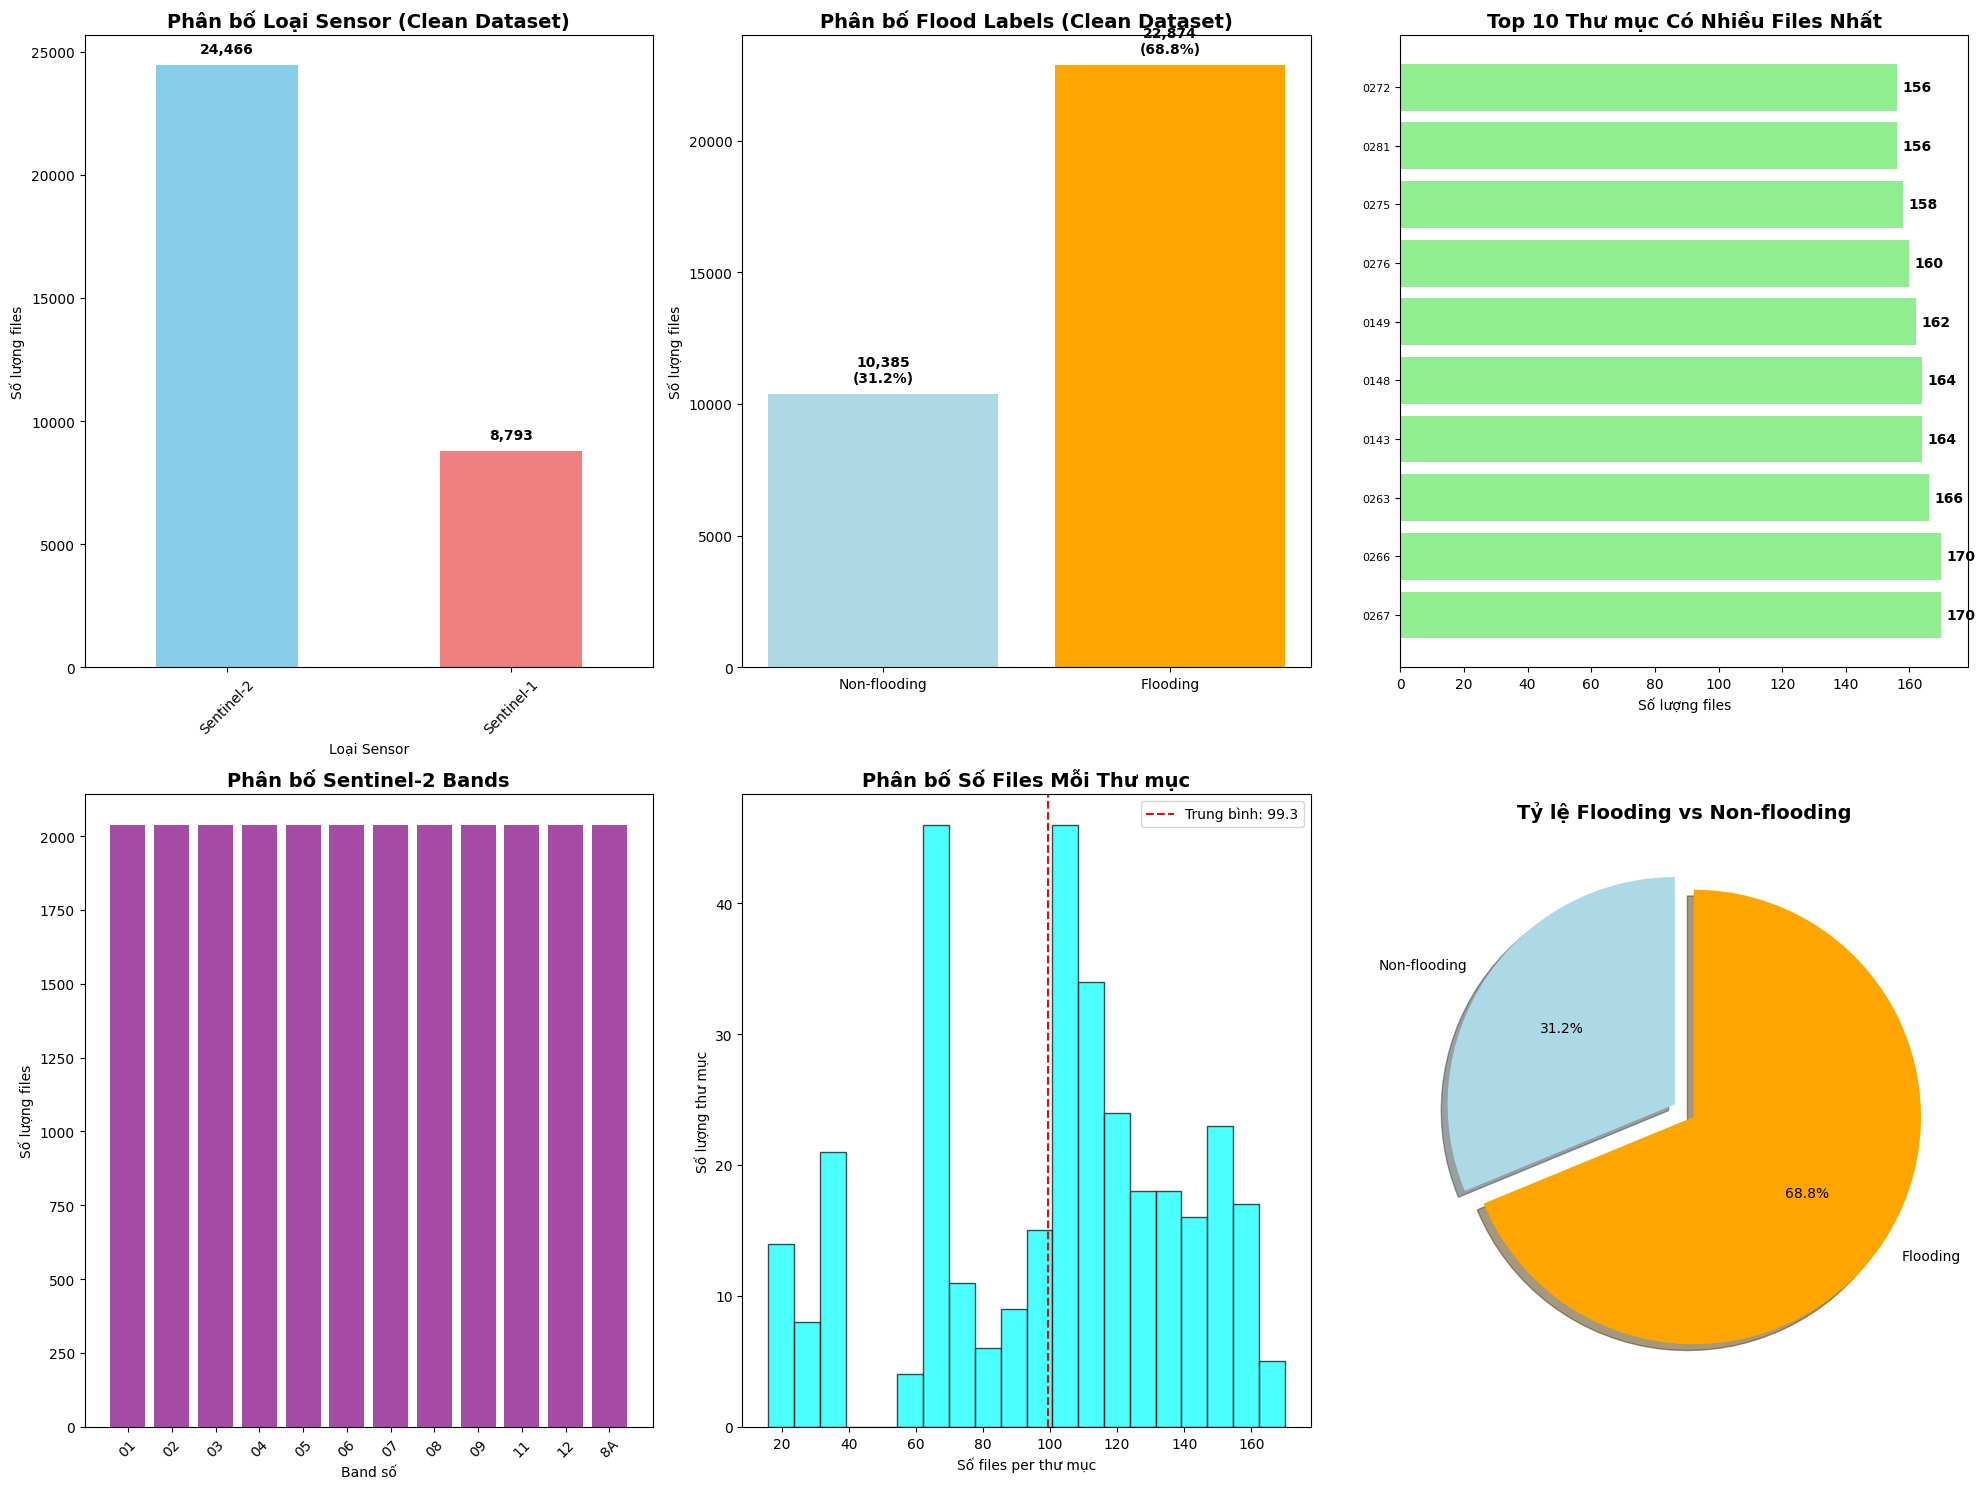

Đã tạo tất cả biểu đồ thống kê!


In [23]:
print("\n" + "="*50)
print("5. TẠO CÁC BIỂU ĐỒ THỐNG KÊ")
print("="*50)

# Cập nhật lại các thống kê cho clean dataset
sensor_counts = df_sensors["sensor"].value_counts()
dataset_folder_names = [os.path.basename(os.path.dirname(file)) for file in tif_files]
mapped_labels = [flood_labels.get(folder, 0) for folder in dataset_folder_names]
label_distribution = Counter(mapped_labels)

# Thiết lập figure với multiple subplots
fig = plt.figure(figsize=(20, 15))

# Biểu đồ 1: Phân bố sensor types
plt.subplot(2, 3, 1)
sensor_counts.plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Phân bố Loại Sensor (Clean Dataset)', fontsize=14, fontweight='bold')
plt.ylabel('Số lượng files')
plt.xlabel('Loại Sensor')
plt.xticks(rotation=45)
# Thêm số liệu lên các cột
for i, v in enumerate(sensor_counts.values):
    plt.text(i, v + max(sensor_counts.values)*0.02, f'{v:,}', ha='center', fontweight='bold')

# Biểu đồ 2: Phân bố flood labels
plt.subplot(2, 3, 2)
labels = ['Non-flooding', 'Flooding']
colors = ['lightblue', 'orange']
values = [label_distribution[0], label_distribution[1]]
bars = plt.bar(labels, values, color=colors)
plt.title('Phân bố Flood Labels (Clean Dataset)', fontsize=14, fontweight='bold')
plt.ylabel('Số lượng files')
# Thêm phần trăm lên các cột
for i, v in enumerate(values):
    plt.text(i, v + max(values)*0.02, f'{v:,}\n({v/sum(values)*100:.1f}%)', 
             ha='center', fontweight='bold')

# Biểu đồ 3: Top 10 thư mục có nhiều file nhất
plt.subplot(2, 3, 3)
top_folders = folder_counts.most_common(10)
folders, counts = zip(*top_folders)
plt.barh(range(len(folders)), counts, color='lightgreen')
plt.title('Top 10 Thư mục Có Nhiều Files Nhất', fontsize=14, fontweight='bold')
plt.xlabel('Số lượng files')
plt.yticks(range(len(folders)), folders, fontsize=8)
for i, v in enumerate(counts):
    plt.text(v + max(counts)*0.01, i, f'{v}', va='center', fontweight='bold')

# Biểu đồ 4: Phân bố Sentinel-2 bands
plt.subplot(2, 3, 4)
if s2_band_counts:
    bands_sorted = sorted(s2_band_counts.keys(), key=lambda x: int(x) if x.isdigit() else 999)
    band_values = [s2_band_counts[band] for band in bands_sorted]
    bars = plt.bar(bands_sorted, band_values, color='purple', alpha=0.7)
    plt.title('Phân bố Sentinel-2 Bands', fontsize=14, fontweight='bold')
    plt.xlabel('Band số')
    plt.ylabel('Số lượng files')
    plt.xticks(rotation=45)

# Biểu đồ 5: Histogram số files per folder
plt.subplot(2, 3, 5)
files_per_folder = list(folder_counts.values())
plt.hist(files_per_folder, bins=20, color='cyan', alpha=0.7, edgecolor='black')
plt.title('Phân bố Số Files Mỗi Thư mục', fontsize=14, fontweight='bold')
plt.xlabel('Số files per thư mục')
plt.ylabel('Số lượng thư mục')
plt.axvline(np.mean(files_per_folder), color='red', linestyle='--', 
           label=f'Trung bình: {np.mean(files_per_folder):.1f}')
plt.legend()

# Biểu đồ 6: Pie chart cho flood labels
plt.subplot(2, 3, 6)
if len(label_distribution) > 1:
    labels_pie = ['Non-flooding', 'Flooding']
    values_pie = [label_distribution[0], label_distribution[1]]
    colors_pie = ['lightblue', 'orange']
    explode = (0.05, 0.05)  # Tách nhẹ các phần
    
    plt.pie(values_pie, labels=labels_pie, colors=colors_pie, explode=explode,
            autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title('Tỷ lệ Flooding vs Non-flooding', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Đã tạo tất cả biểu đồ thống kê!")


## 10. Visualization các Sample Images

Hiển thị sample images để so sánh trực quan giữa các scenario:

### Layout Visualization:
- **Row 1**: Sentinel-1 SAR images - Flooded areas
- **Row 2**: Sentinel-1 SAR images - Non-flooded areas  
- **Row 3**: Sentinel-2 True color - Flooded areas
- **Row 4**: Sentinel-2 True color - Non-flooded areas

### Key Observations:
- **SAR signatures**: Flooded areas thường có **lower backscatter** (darker)
- **Optical differences**: Flooded areas có **water reflection** khác biệt
- **Spatial patterns**: Flood extent và distribution patterns
- **Sensor complementarity**: SAR penetrates clouds, Optical shows natural colors

### Technical Notes:
- **S1 images**: Converted to grayscale với min-max normalization
- **S2 images**: RGB composite từ B02/B03/B04 với percentile stretch



6. VISUALIZATION CÁC SAMPLES IMAGES
Sentinel-1: 5 flooded, 5 non-flooded samples
Sentinel-2: 5 flooded, 5 non-flooded B04 files


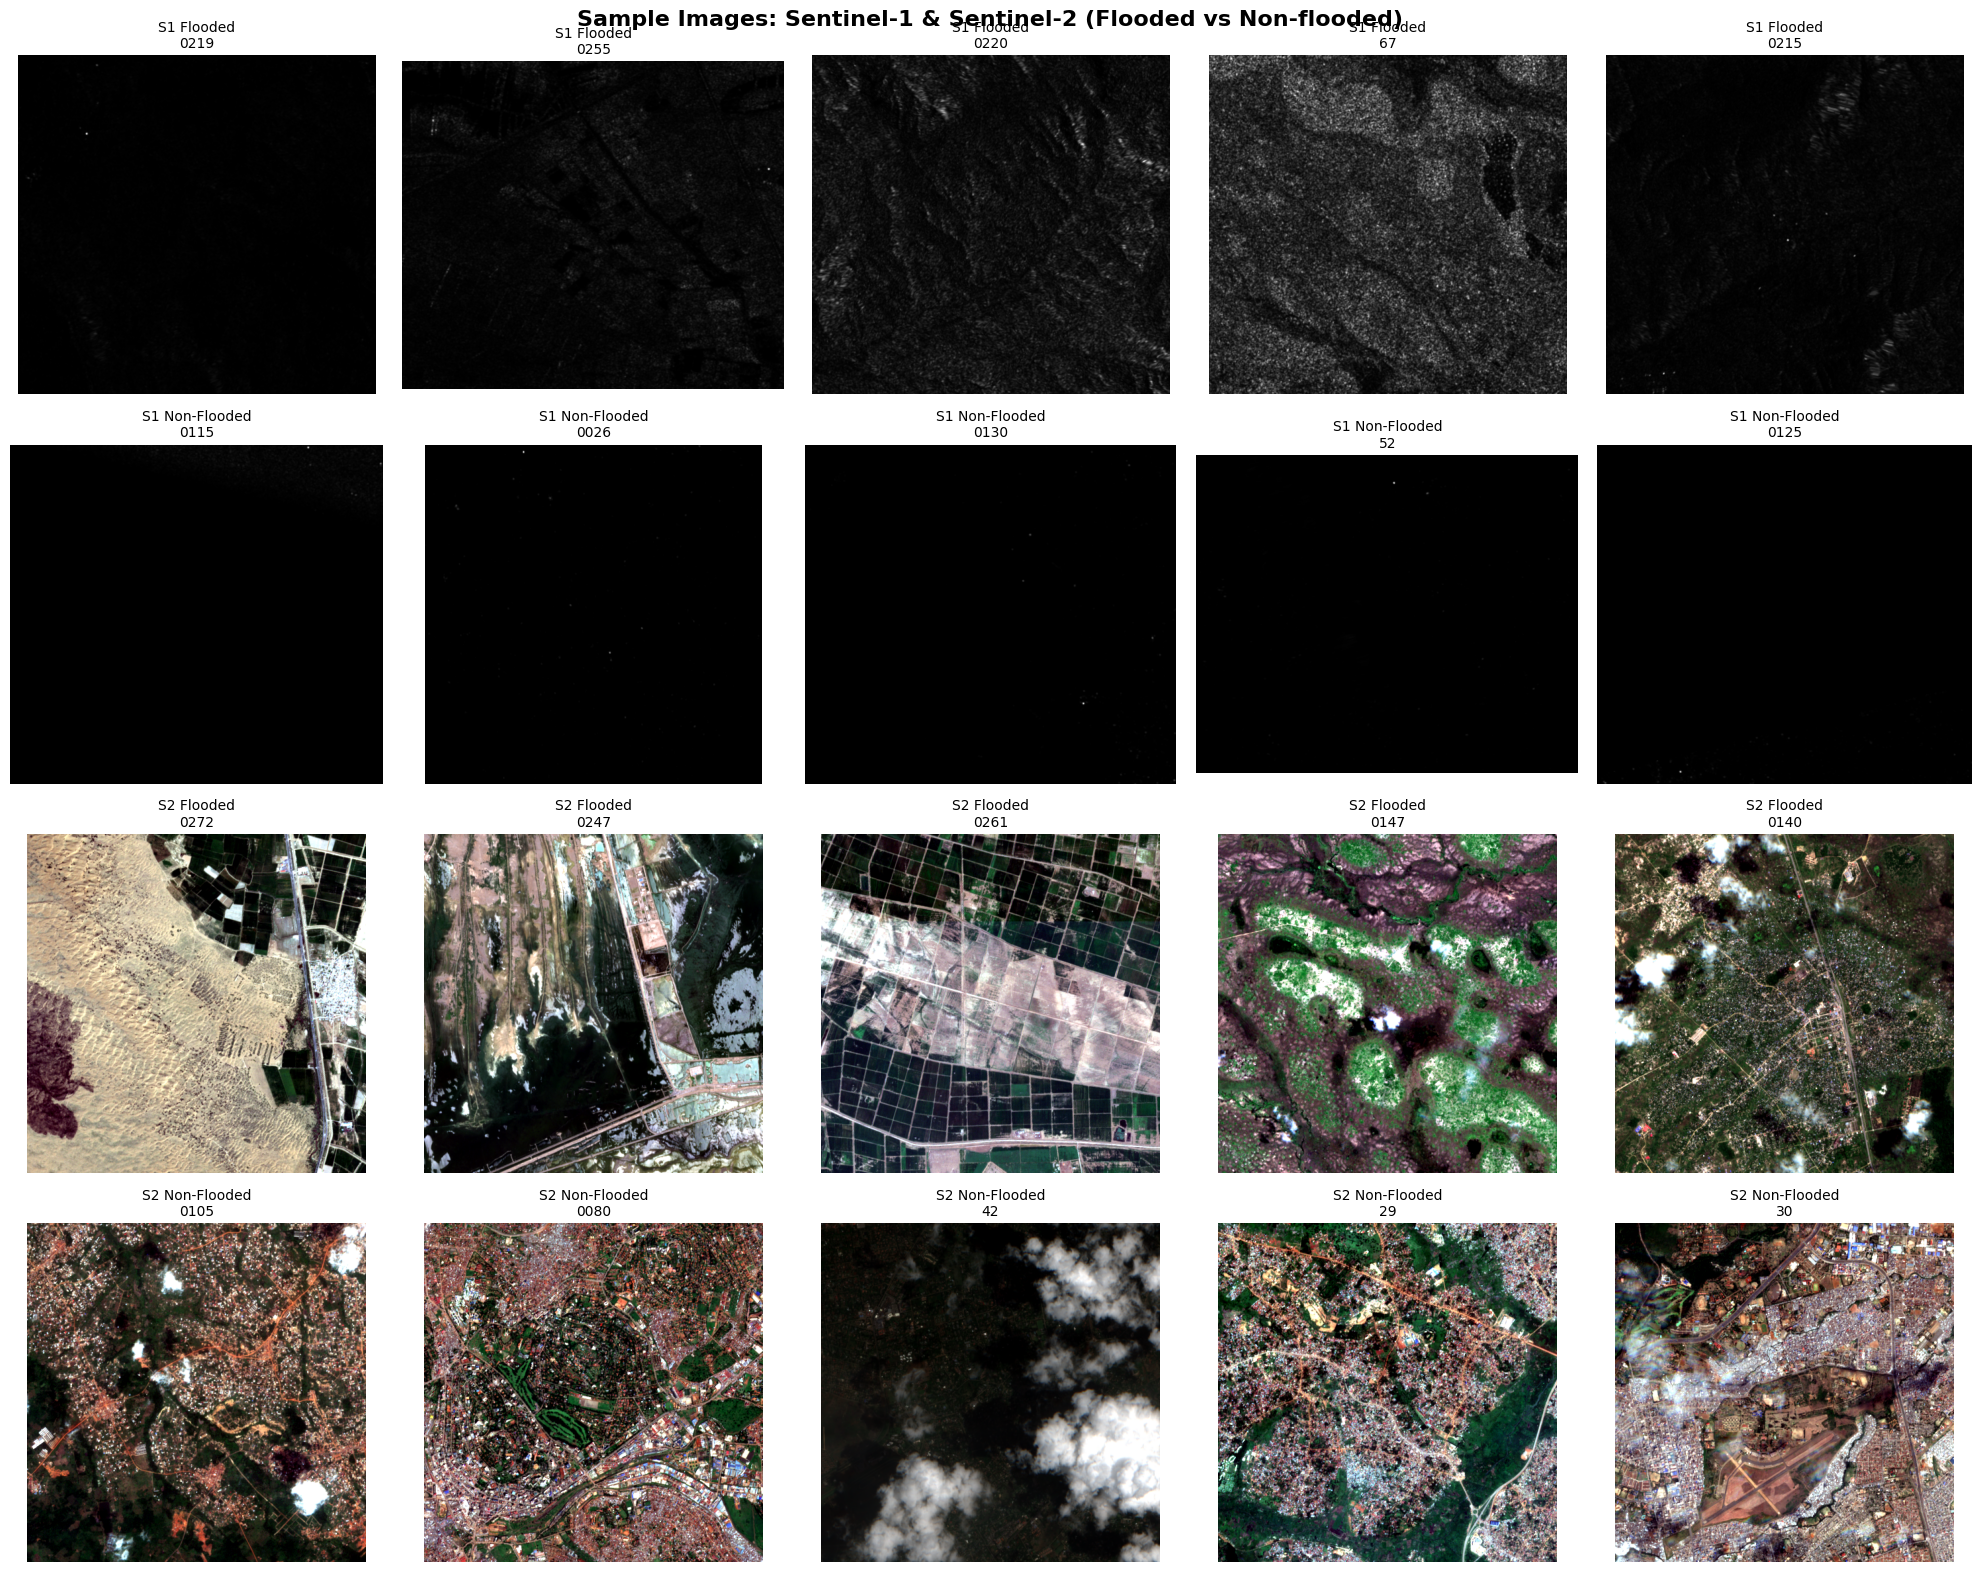

Đã hiển thị sample images!


In [24]:
print("\n" + "="*50)
print("6. VISUALIZATION CÁC SAMPLES IMAGES")
print("="*50)

# Sampling Sentinel-1 images theo flood labels
s1_flooded = [fp for fp in sentinel1_files 
              if flood_labels.get(os.path.basename(os.path.dirname(fp)), 0) == 1]
s1_non = [fp for fp in sentinel1_files 
          if flood_labels.get(os.path.basename(os.path.dirname(fp)), 0) == 0]

n_samples = 5  # Số samples hiển thị
s1_flooded_samples = random.sample(s1_flooded, min(len(s1_flooded), n_samples))
s1_non_samples = random.sample(s1_non, min(len(s1_non), n_samples))

print(f"Sentinel-1: {len(s1_flooded_samples)} flooded, {len(s1_non_samples)} non-flooded samples")

# Sampling Sentinel-2 B04 files (để có thể tạo true color)
s2_b04 = [fp for fp in sentinel2_files if fp.endswith("_B04.tif")]
s2_b04_flooded = [fp for fp in s2_b04 
                  if flood_labels.get(os.path.basename(os.path.dirname(fp)), 0) == 1]
s2_b04_non = [fp for fp in s2_b04 
              if flood_labels.get(os.path.basename(os.path.dirname(fp)), 0) == 0]

s2_b04_flooded_samples = random.sample(s2_b04_flooded, min(len(s2_b04_flooded), n_samples))
s2_b04_non_samples = random.sample(s2_b04_non, min(len(s2_b04_non), n_samples))

print(f"Sentinel-2: {len(s2_b04_flooded_samples)} flooded, {len(s2_b04_non_samples)} non-flooded B04 files")

# Tạo figure với 4 rows x 5 columns để hiển thị samples
fig, axes = plt.subplots(4, 5, figsize=(20, 16))

# Row 0: Sentinel-1 flooded images
for i, fp in enumerate(s1_flooded_samples):
    img = load_s1_gray(fp)
    axes[0, i].imshow(img, cmap="gray")
    folder_name = os.path.basename(os.path.dirname(fp))
    axes[0, i].set_title(f"S1 Flooded\n{folder_name}", fontsize=10)
    axes[0, i].axis("off")

# Fill empty slots if needed
for i in range(len(s1_flooded_samples), 5):
    axes[0, i].axis("off")

# Row 1: Sentinel-1 non-flooded images  
for i, fp in enumerate(s1_non_samples):
    img = load_s1_gray(fp)
    axes[1, i].imshow(img, cmap="gray")
    folder_name = os.path.basename(os.path.dirname(fp))
    axes[1, i].set_title(f"S1 Non-Flooded\n{folder_name}", fontsize=10)
    axes[1, i].axis("off")

# Fill empty slots if needed
for i in range(len(s1_non_samples), 5):
    axes[1, i].axis("off")

# Row 2: Sentinel-2 flooded images (true color)
for i, fp in enumerate(s2_b04_flooded_samples):
    img = load_s2_true_color(fp)
    axes[2, i].imshow(img)
    folder_name = os.path.basename(os.path.dirname(fp))
    axes[2, i].set_title(f"S2 Flooded\n{folder_name}", fontsize=10)
    axes[2, i].axis("off")

# Fill empty slots if needed
for i in range(len(s2_b04_flooded_samples), 5):
    axes[2, i].axis("off")

# Row 3: Sentinel-2 non-flooded images (true color)
for i, fp in enumerate(s2_b04_non_samples):
    img = load_s2_true_color(fp)
    axes[3, i].imshow(img)
    folder_name = os.path.basename(os.path.dirname(fp))
    axes[3, i].set_title(f"S2 Non-Flooded\n{folder_name}", fontsize=10)
    axes[3, i].axis("off")

# Fill empty slots if needed
for i in range(len(s2_b04_non_samples), 5):
    axes[3, i].axis("off")

plt.suptitle('Sample Images: Sentinel-1 & Sentinel-2 (Flooded vs Non-flooded)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("Đã hiển thị sample images!")


## 11. Phân tích Kích thước và Metadata Chi tiết

Phân tích technical specifications của images để hiểu dataset ở mức technical:

### Metadata Analysis:
- **Dimensions**: Width x Height của images
- **Data types**: Kiểu dữ liệu (float32, uint16, etc.)
- **Coordinate systems**: CRS information
- **Band counts**: Số bands per file

### Outputs:
- **Dimension histograms**: Phân bố width/height
- **Statistics by sensor**: So sánh specs giữa S1 và S2
- **Common formats**: Tìm format phổ biến nhất

### Why Important:
- **Training preparation**: Biết image sizes để thiết kế model
- **Memory planning**: Ước tính RAM requirements  
- **Quality checks**: Phát hiện outliers về kích thước



7. PHÂN TÍCH KÍCH THƯỚC VÀ METADATA
Đang phân tích metadata từ 100 sample files...
THỐNG KÊ KÍCH THƯỚC IMAGES:
  Kích thước phổ biến nhất: 256 x 256
  Số bands trung bình: 1.0
  Data types: {'uint16': 69, 'float32': 31}

THỐNG KÊ THEO SENSOR:
                 width                  height            bands     
                  mean         std        mean        std  mean  std
sensor                                                              
Sentinel-1  563.161290   37.255959  521.387097    3.63022   1.0  0.0
Sentinel-2  312.826087  159.511290  312.826087  159.51129   1.0  0.0


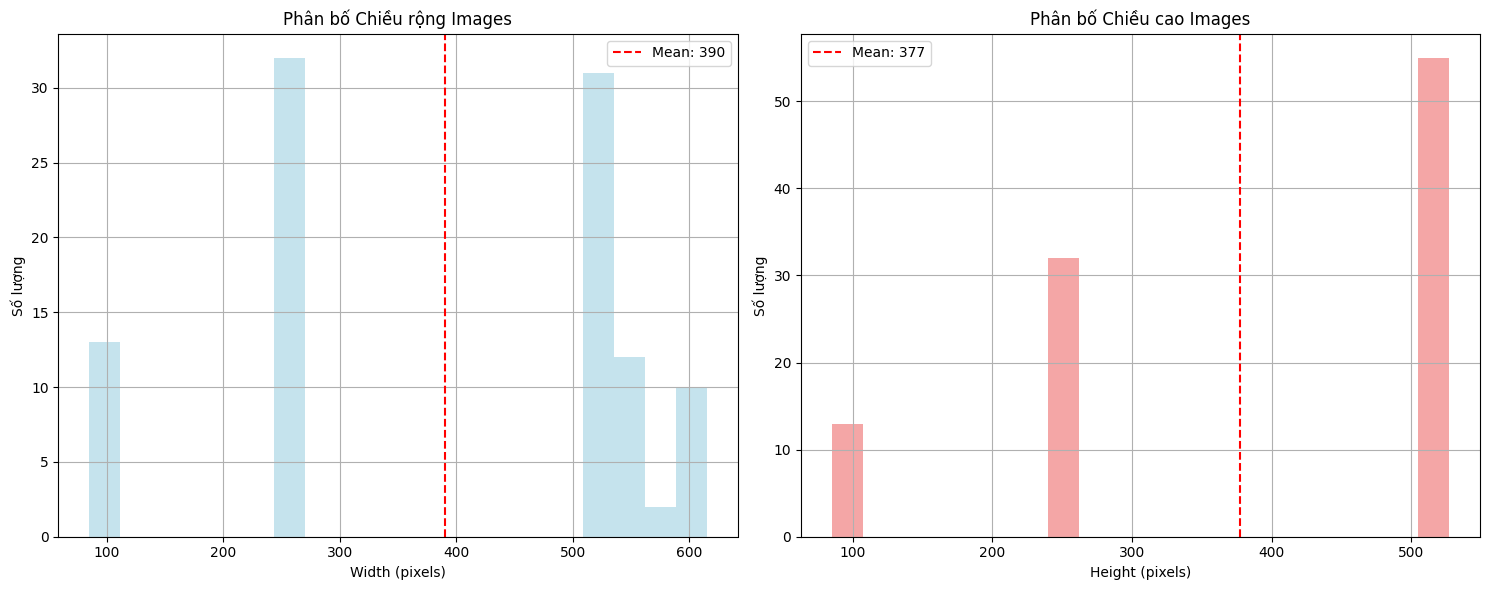

Hoàn thành phân tích metadata!


In [25]:
print("\n" + "="*50)
print("7. PHÂN TÍCH KÍCH THƯỚC VÀ METADATA")
print("="*50)

# Lấy sample để phân tích (không cần phân tích tất cả để tiết kiệm thời gian)
sample_size = min(100, len(tif_files))
sample_files = random.sample(tif_files, sample_size)
file_info = []

print(f"Đang phân tích metadata từ {sample_size} sample files...")

for file_path in sample_files:
    try:
        with rasterio.open(file_path) as src:
            info = {
                'file': os.path.basename(file_path),
                'width': src.width,
                'height': src.height,
                'bands': src.count,
                'dtype': str(src.dtypes[0]),
                'crs': str(src.crs),
                'sensor': classify_sensor(file_path)
            }
            file_info.append(info)
    except Exception as e:
        print(f"Lỗi đọc metadata từ {file_path}: {e}")

# Tạo DataFrame từ metadata
df_info = pd.DataFrame(file_info)

if not df_info.empty:
    print("THỐNG KÊ KÍCH THƯỚC IMAGES:")
    print(f"  Kích thước phổ biến nhất: {df_info['width'].mode().iloc[0]} x {df_info['height'].mode().iloc[0]}")
    print(f"  Số bands trung bình: {df_info['bands'].mean():.1f}")
    print(f"  Data types: {df_info['dtype'].value_counts().to_dict()}")
    
    # Thống kê theo sensor
    print(f"\nTHỐNG KÊ THEO SENSOR:")
    sensor_stats = df_info.groupby('sensor')[['width', 'height', 'bands']].agg(['mean', 'std'])
    print(sensor_stats)
    
    # Tạo biểu đồ phân bố kích thước
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histogram chiều rộng
    df_info['width'].hist(bins=20, ax=axes[0], color='lightblue', alpha=0.7)
    axes[0].set_title('Phân bố Chiều rộng Images')
    axes[0].set_xlabel('Width (pixels)')
    axes[0].set_ylabel('Số lượng')
    axes[0].axvline(df_info['width'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df_info["width"].mean():.0f}')
    axes[0].legend()
    
    # Histogram chiều cao
    df_info['height'].hist(bins=20, ax=axes[1], color='lightcoral', alpha=0.7)
    axes[1].set_title('Phân bố Chiều cao Images')
    axes[1].set_xlabel('Height (pixels)')
    axes[1].set_ylabel('Số lượng')
    axes[1].axvline(df_info['height'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df_info["height"].mean():.0f}')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("Hoàn thành phân tích metadata!")
else:
    print("Không thể phân tích metadata từ sample files")


## 12. Tạo Summary Report

Tổng hợp tất cả kết quả EDA thành báo cáo cuối cùng:

### Summary Report bao gồm:
1. **Key Statistics**: Tổng số files, folders, sensors
2. **Class Distribution**: Tỷ lệ flooding vs non-flooding
3. **Data Quality**: Kết quả sau data cleaning
4. **Technical Specs**: Image dimensions, formats
5. **Files Created**: Danh sách output files cho training

### Output Files được tạo:
- `clean_dataset_info.json` - Dataset đã clean cho training
- `invalid_files_info.json` - Thông tin về invalid files  
- `flood_labels_mapping.json` - Labels mapping cho training

### Ready for Training:
Sau EDA này, `training` sẽ tự động detect và sử dụng clean dataset!


In [26]:
print("\n" + "="*50)
print("8. TẠO SUMMARY REPORT")
print("="*50)

# Tạo dictionary chứa tất cả thống kê quan trọng
summary_stats = {
    'total_files': len(tif_files),
    'unique_folders': len(folder_counts),
    'sentinel1_files': len(sentinel1_files),
    'sentinel2_files': len(sentinel2_files),
    'other_files': len(valid_other_files),
    'flooded_samples': label_distribution[1],
    'non_flooded_samples': label_distribution[0],
    'sentinel2_bands': len(s2_band_counts),
    'max_files_per_folder': folder_counts.most_common(1)[0][1],
    'avg_files_per_folder': np.mean(list(folder_counts.values()))
}

# Tạo summary table
summary_data = {
    'Metric': [
        'Tổng số files TIFF (Clean)',
        'Số thư mục duy nhất',
        'Sentinel-1 files',
        'Sentinel-2 files',
        'Files khác',
        'Flooded samples',
        'Non-flooded samples',
        'Sentinel-2 bands',
        'Thư mục có nhiều files nhất',
        'Files per thư mục (trung bình)'
    ],
    'Value': [
        f"{summary_stats['total_files']:,}",
        f"{summary_stats['unique_folders']:,}",
        f"{summary_stats['sentinel1_files']:,}",
        f"{summary_stats['sentinel2_files']:,}",
        f"{summary_stats['other_files']:,}",
        f"{summary_stats['flooded_samples']:,}",
        f"{summary_stats['non_flooded_samples']:,}",
        f"{summary_stats['sentinel2_bands']}",
        f"{summary_stats['max_files_per_folder']}",
        f"{summary_stats['avg_files_per_folder']:.1f}"
    ]
}

summary_df = pd.DataFrame(summary_data)

print("SUMMARY REPORT:")
print(summary_df.to_string(index=False))

# Tạo additional insights
print(f"\nADDITIONAL INSIGHTS:")
print(f"  • Dataset có {summary_stats['flooded_samples']/(summary_stats['flooded_samples']+summary_stats['non_flooded_samples'])*100:.1f}% flooding samples")
print(f"  • Sentinel-2 chiếm {summary_stats['sentinel2_files']/summary_stats['total_files']*100:.1f}% tổng số files")
print(f"  • Trung bình mỗi folder có {summary_stats['avg_files_per_folder']:.1f} files")
print(f"  • Có {summary_stats['sentinel2_bands']} bands khác nhau trong Sentinel-2")
print(f"  • Class imbalance ratio: {summary_stats['non_flooded_samples']/summary_stats['flooded_samples']:.1f}:1 (non-flood:flood)")

# Export các variables quan trọng cho sử dụng sau này
print(f"\nCÁC VARIABLES ĐÃ TẠO:")
print(f"  • tif_files: List of all clean TIFF file paths")
print(f"  • flood_labels: Dictionary mapping folder -> flood label")
print(f"  • sentinel1_files, sentinel2_files: Lists phân theo sensor")
print(f"  • df_sensors: DataFrame chứa thông tin tất cả files")
print(f"  • summary_stats: Dictionary chứa tất cả thống kê")

print(f"\nFILES ĐÃ TẠO:")
print(f"  • clean_dataset_info.json - Clean dataset cho training")
print(f"  • invalid_files_info.json - Danh sách invalid files")
print(f"  • flood_labels_mapping.json - Labels mapping cho training")
print(f"Tất cả files đã lưu tại: {data_dir}")

print("\n" + "="*60)
print("HOÀN THÀNH EXPLORATORY DATA ANALYSIS!")
print("="*60)
print("Dataset đã được cleaned và prepared")
print("Metadata và labels đã được analyzed")  
print("Visualization đã được tạo")
print("Summary statistics đã được calculated")
print("SẴN SÀNG CHO TRAINING với tensorflow_training.py!")
print("="*60)



8. TẠO SUMMARY REPORT
SUMMARY REPORT:
                        Metric  Value
    Tổng số files TIFF (Clean) 33,259
           Số thư mục duy nhất    335
              Sentinel-1 files  8,793
              Sentinel-2 files 24,466
                    Files khác      0
               Flooded samples 22,874
           Non-flooded samples 10,385
              Sentinel-2 bands     12
   Thư mục có nhiều files nhất    170
Files per thư mục (trung bình)   99.3

ADDITIONAL INSIGHTS:
  • Dataset có 68.8% flooding samples
  • Sentinel-2 chiếm 73.6% tổng số files
  • Trung bình mỗi folder có 99.3 files
  • Có 12 bands khác nhau trong Sentinel-2
  • Class imbalance ratio: 0.5:1 (non-flood:flood)

CÁC VARIABLES ĐÃ TẠO:
  • tif_files: List of all clean TIFF file paths
  • flood_labels: Dictionary mapping folder -> flood label
  • sentinel1_files, sentinel2_files: Lists phân theo sensor
  • df_sensors: DataFrame chứa thông tin tất cả files
  • summary_stats: Dictionary chứa tất cả thống kê

FILES ĐÃ T